In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [3]:
df = pd.read_csv("expense3.csv")
df.head()

,Category,Expense
0,Entertainment,Music
1,Food,Eating at a Cafe
2,Food,Coffee
3,Travel,Car repair
4,Entertainment,Gaming


In [4]:
df['category_id'] = df['Category'].factorize()[0]
category_id_df = df[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)
df

,Category,Expense,category_id
0,Entertainment,Music,0
1,Food,Eating at a Cafe,1
2,Food,Coffee,1
3,Travel,Car repair,2
4,Entertainment,Gaming,0
...,...,...,...
319,Savings,Retirement Savings,6
320,Travel,Airfare,2
321,Travel,Kit bag,2
322,Housing,Trash Collection,5


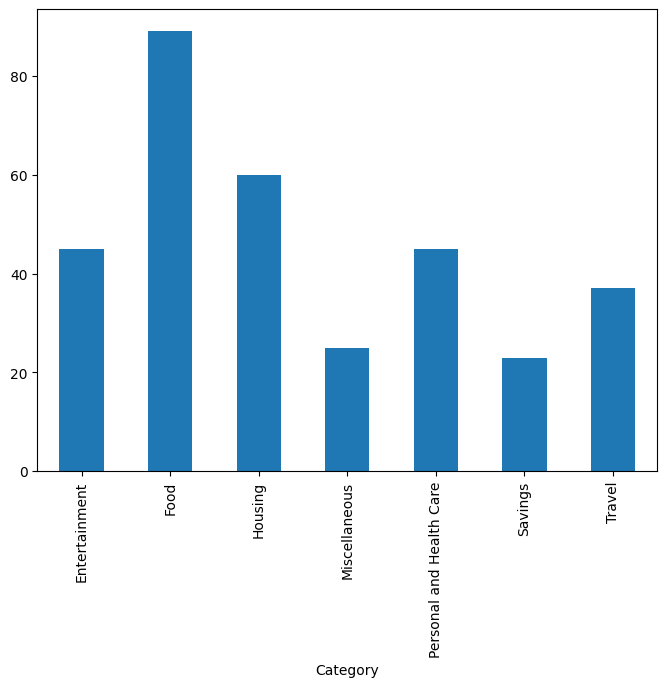

In [7]:
fig = plt.figure(figsize=(8,6))
df.groupby("Category").Expense.count().plot.bar(ylim=0)
plt.show()

In [9]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='UTF-8', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Expense).toarray()
labels = df.category_id
features.shape

(324, 5)

In [11]:
N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
     

# 'Entertainment':
  . Most correlated unigrams:
. savings
. tickets
  . Most correlated bigrams:
. 
# 'Food':
  . Most correlated unigrams:
. tickets
. chicken
  . Most correlated bigrams:
. 
# 'Housing':
  . Most correlated unigrams:
. tickets
. home
  . Most correlated bigrams:
. 
# 'Miscellaneous':
  . Most correlated unigrams:
. savings
. tickets
  . Most correlated bigrams:
. 
# 'Personal and Health Care':
  . Most correlated unigrams:
. savings
. tickets
  . Most correlated bigrams:
. 
# 'Savings':
  . Most correlated unigrams:
. tickets
. savings
  . Most correlated bigrams:
. 
# 'Travel':
  . Most correlated unigrams:
. tickets
. car
  . Most correlated bigrams:
. 


In [12]:
X_train, X_test, y_train, y_test = train_test_split(df['Expense'], df['Category'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = LogisticRegression().fit(X_train_tfidf, y_train)

In [13]:
print(clf.predict(count_vect.transform(["Mc aloo tikki burger"])))

['Food']


In [14]:
print(clf.predict(count_vect.transform(["Hair gel"])))

['Personal and Health Care']


In [17]:
print(clf.predict(count_vect.transform(["Auto fare"])))

['Travel']


In [18]:
print(clf.predict(count_vect.transform(["Benne Masala dosa"])))

['Food']


In [19]:
print(clf.predict(count_vect.transform(["Netflix"])))

['Entertainment']


In [20]:
print(clf.predict(count_vect.transform(["Movie ticket"])))

['Entertainment']


In [21]:
print(clf.predict(count_vect.transform(["Electric bill"])))

['Housing']


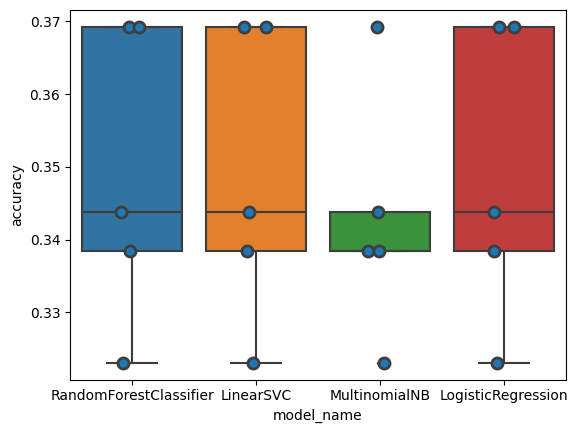

In [22]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [23]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.348750
LogisticRegression        0.348750
MultinomialNB             0.342596
RandomForestClassifier    0.348750
Name: accuracy, dtype: float64

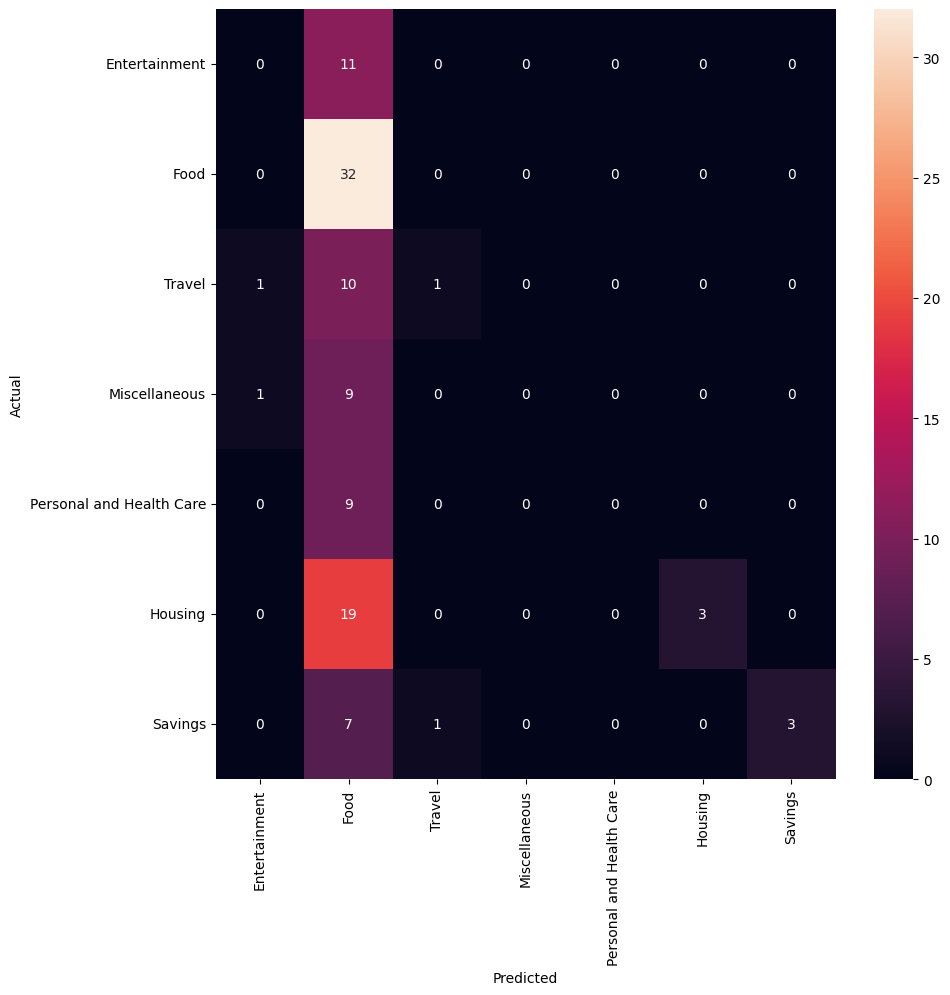

In [24]:
model = LogisticRegression()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [26]:
#what all were predicted wrong
from IPython.display import display
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Category', 'Expense']])
      print('')

'Entertainment' predicted as 'Food' : 11 examples.


,Category,Expense
179,Entertainment,Club Membership
22,Entertainment,Xbox
230,Entertainment,Museum
158,Entertainment,PC
120,Entertainment,Casino
222,Entertainment,Carnivals
247,Entertainment,Parties
268,Entertainment,TV show
46,Entertainment,Novels
145,Entertainment,Theater



'Travel' predicted as 'Food' : 10 examples.


,Category,Expense
167,Travel,Taxi Fare
218,Travel,Auto rickshaw
12,Travel,Uber Ride
136,Travel,Luggage bag
17,Travel,Motor bike
33,Travel,Camping Gear
304,Travel,Hotel Accommodation
45,Travel,Rapido
20,Travel,Train Fare
214,Travel,Bike



'Housing' predicted as 'Food' : 19 examples.


,Category,Expense
101,Housing,Ovens
159,Housing,Appliances
181,Housing,Sewer clean
64,Housing,Light bulbs
108,Housing,Sofa
66,Housing,Tablesw
161,Housing,Desks
305,Housing,Drills
21,Housing,Detergent
59,Housing,Gunny bag


In [27]:
print(clf.predict(count_vect.transform(["Tables"])))

['Food']


In [28]:
print(clf.predict(count_vect.transform(["Medicines"])))

['Food']


In [29]:
print(clf.predict(count_vect.transform(["concert"])))

['Entertainment']


In [ ]:
print(clf.predict(count_vect.transform([""])))